# Dataset Overview (for Amazon Reviews, Essays)

In [35]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt

reviews_parent_dir = 'datasets/reviews/'
essays_parent_dir = 'datasets/asap-aes/'

def load_reviews(files=None, nrows_per_type=None):
    if not files:
        files = [f for f in os.listdir('datasets/reviews/') if f.split('.')[1]=='json']
    dfs = []
    for f in files:
        df = pd.read_json(reviews_parent_dir + f, lines=True, nrows=nrows_per_type)
        df['type'] = f.split('-')[0]
        dfs.append(df)
    return pd.concat(dfs).reset_index()

def load_essays(train=True, valid=True, test=True):
    files = []
    if train: files.append('train_set.json')
    if valid: files.append('valid_set.json')
    if test:  files.append('test_set.json')
    return (pd.read_json(essays_parent_dir + f, lines=False) for f in files)

# Amazon Reviews

In [74]:
reviews_data = load_reviews()

In [67]:
reviews_data.head()

,index,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,type
0,0,5,True,"08 22, 2013",A34A1UP40713F8,B00009W3I4,{'Style:': ' Dryer Vent'},James. Backus,I like this as a vent as well as something tha...,Great product,1377129600,NaN,NaN,appliances
1,1,5,True,"02 8, 2016",A1AHW6I678O6F2,B00009W3PA,{'Size:': ' 6-Foot'},kevin.,good item,Five Stars,1454889600,NaN,NaN,appliances
2,2,5,True,"08 5, 2015",A8R48NKTGCJDQ,B00009W3PA,{'Size:': ' 6-Foot'},CDBrannom,Fit my new LG dryer perfectly.,Five Stars,1438732800,NaN,NaN,appliances
3,3,5,True,"04 24, 2015",AR3OHHHW01A8E,B00009W3PA,{'Size:': ' 6-Foot'},Calvin E Reames,Good value for electric dryers,Perfect size,1429833600,NaN,NaN,appliances
4,4,5,True,"03 21, 2015",A2CIEGHZ7L1WWR,B00009W3PA,{'Size:': ' 6-Foot'},albert j. kong,Price and delivery was excellent.,Five Stars,1426896000,NaN,NaN,appliances


### Sample Reviews

In [75]:
# NOTE:  It appears that 'books' contains some reviews that regard remotes / chargers ...

def show_reviews(nsample=1):
    for group in reviews_data.groupby('type'):
        group = group[1].reset_index()
        print('---------------------------------- ({t}) --------------------------------'.format(t=group['type'][0]))
        for _, row in group.sample(n=nsample).iterrows():
            print('\n(Score: {s})  {r}\n'.format(s=row['overall'], r=row['reviewText']))
            print("---------------------------------------------------------------------------")

show_reviews(2)

---------------------------------- (appliances) --------------------------------

(Score: 5)  We have 24 foot of solid dryer vent pipe ending in 3 right-angles before going through the floor into the flexible dryer-vent hose coming from the dryer.  I can't get behind the dryer without moving both the washer and dryer and they are HEAVY.  So being lazy I decided to clean the vent from the outside of the house inward.  I didn't use a vacuum cleaner or a blower or suction of any kind.  I did tighten each section of tubing with pliers and taped them.  I threaded all 24 foot of tubing with the brush on the end into the outside vent and then backed it out.  I got a good amount of lint clods out.  Then I turned on the dryer to blow everything out.  I got no air coming out at all.  My fear had come true, I had forced gobs of lint into the right-angles at the end of the run.  I still didn't want to move that washer and dryer so I figured I'd try one other thing, use the clodbuster attachment.  

### Summary Statistics

In [95]:
LEFT_ADJUST = 28

for dataset in ['all', *reviews_data['type'].unique()]:
    data = reviews_data if (dataset=='all') else reviews_data[reviews_data['type']==dataset]
    
    word_tokens = set()
    char_tokens = set()
    sum_rev_len = 0
    for text in data['reviewText']:
        if type(text) == str:
            sum_rev_len += len(text)
            for token in re.split(r'\s{1,}', text):  word_tokens.add(token)
            for c in text:  char_tokens.add(c)
    print("------------- ({s}) --------------".format(s=dataset))
    print("# Reviews:  ", len(data))
    print("# Unique words:  ", len(word_tokens))
    print("# Unique characters:  ", len(char_tokens))
    print("Average Review Length:  ", np.round_(sum_rev_len / len(data), 2), "chars")
    print("Average Overall Rating:  ", np.round_(data['overall'].mean(), 2))
    print()
print()
print("------------------- Score Summaries -------------------")
print((" "*LEFT_ADJUST + "\tavg rating\tmax\tmin\n"))
for group in reviews_data.groupby('type'):
    df = group[1]
    print(group[0].ljust(LEFT_ADJUST) + "\t{avg}\t{mx}\t{mn}".format(
        avg=np.round_(df['overall'].mean(), 8),
        mn=df['overall'].max(),
        mx=df['overall'].min()
    ))
print()
print("Possible values for 'overall':\t", sorted(reviews_data['overall'].unique()))

------------- (all) --------------
# Reviews:   41290
# Unique words:   111034
# Unique characters:   98
Average Review Length:   381.81 chars
Average Overall Rating:   4.37

------------- (appliances) --------------
# Reviews:   2277
# Unique words:   1986
# Unique characters:   87
Average Review Length:   1481.95 chars
Average Overall Rating:   4.5

------------- (arts_crafts_and_sewing) --------------
# Reviews:   3001
# Unique words:   13254
# Unique characters:   91
Average Review Length:   207.92 chars
Average Overall Rating:   4.57

------------- (automotive) --------------
# Reviews:   3001
# Unique words:   15773
# Unique characters:   93
Average Review Length:   244.68 chars
Average Overall Rating:   4.34

------------- (books) --------------
# Reviews:   3001
# Unique words:   23091
# Unique characters:   92
Average Review Length:   429.42 chars
Average Overall Rating:   4.21

------------- (cellphones_and_accessories) --------------
# Reviews:   3001
# Unique words:   24945

# Essays

This dataset contains 8 different essay sets, each associated with a particular prompt.
* Personally identifying information has been replaced with NER (Named Entity Recognition) tags [Ex: "Person", "Organization", etc.]

## Loading (and cleaning) Data

* All of the score columns were of datatype ('object'), and missing values were ('').

 **Steps for Cleaning Data:**
 
   1) Replace '' with nans (NULLs)
 
   2) Convert score columns to int64

In [3]:
essays_train, essays_valid, essays_test = load_essays()  # (train, valid, test)

for df in [essays_train, essays_valid, essays_test]:
    df.replace('', np.nan, inplace=True)
    for col in (c for c in df.columns if c not in ['essay_id', 'essay_set', 'essay']):
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

### Train:

In [97]:
essays_train.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,<NA>,8,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,<NA>,9,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,<NA>,7,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,<NA>,10,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,<NA>,8,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


### Valid:

In [10]:
essays_valid.head()

,essay_id,essay_set,essay,domain1_predictionid,domain2_predictionid
0,1788,1,"Dear @ORGANIZATION1, @CAPS1 more and more peop...",1788,
1,1789,1,Dear @LOCATION1 Time @CAPS1 me tell you what I...,1789,
2,1790,1,"Dear Local newspaper, Have you been spending a...",1790,
3,1791,1,"Dear Readers, @CAPS1 you imagine how life woul...",1791,
4,1792,1,"Dear newspaper, I strongly believe that comput...",1792,


### Test:

In [11]:
essays_test.head()

,essay_id,essay_set,essay,domain1_predictionid,domain2_predictionid
0,2383,1.0,I believe that computers have a positive effec...,2383.0,
1,2384,1.0,"Dear @CAPS1, I know some problems have came up...",2384.0,
2,2385,1.0,"Dear to whom it @MONTH1 concern, Computers are...",2385.0,
3,2386,1.0,"Dear @CAPS1 @CAPS2, @CAPS3 has come to my atte...",2386.0,
4,2387,1.0,"Dear Local newspaper, I think that people have...",2387.0,


### Ratings Overview (Train)

In [95]:
score_columns = [c for c in essays_train.columns if c not in ['essay_id', 'essay_set', 'essay']]
essays_train[score_columns].describe()

,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,rater1_trait2,rater1_trait3,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
count,12977.000000,12977.000000,128.000000,12977.000000,1800.000000,1800.000000,1800.000000,2292.000000,2292.000000,2292.000000,...,2292.000000,2292.000000,723.000000,723.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,4.126840,4.137089,37.828125,6.799723,3.333889,3.330556,3.333889,2.444154,2.557592,2.606457,...,2.635689,2.710297,3.777317,3.589212,3.945312,3.890625,4.078125,3.992188,3.843750,3.617188
std,4.212537,4.264320,5.240829,8.970558,0.729103,0.726807,0.729103,1.211730,1.061076,1.098196,...,1.142566,1.045795,0.689401,0.693256,0.643668,0.630390,0.622535,0.509687,0.538845,0.603417
min,0.000000,0.000000,20.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000
25%,2.000000,2.000000,36.000000,2.000000,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000
50%,3.000000,3.000000,40.000000,3.000000,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,...,2.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
75%,4.000000,4.000000,40.000000,8.000000,4.000000,4.000000,4.000000,3.000000,3.000000,4.000000,...,4.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,30.000000,30.000000,50.000000,60.000000,4.000000,4.000000,4.000000,6.000000,6.000000,6.000000,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,5.000000,5.000000


### Ratings Overview (by Group)

In [101]:
score_columns = [c for c in essays_train.columns if c not in ['essay_id', 'essay']]
metrics = ['count', 'mean', 'min', 'max']
op_dict = {
    'count': lambda x: x.astype(int),
    'min': lambda x: x.astype(int),
    'max': lambda x: x.astype(int),
    'mean': lambda x: np.round_(x, 2)
}
def reformat(x, metric):
    x = np.array(x)
    return "None" if pd.isnull(x) else op_dict[metric](x)

print("\t\t\tSet 1\t Set 2\t Set 3\t Set 4\t Set 5\t Set 6\t Set 7\t Set 8")
print("\t\t\t---------------------------------------------------------------")
current_column = None
df = essays_train[score_columns].groupby('essay_set').describe()
for entry in df:
    if current_column != entry[0]:
        print()
        current_column = entry[0]
    if entry[1] in metrics:
        score_params = {'s'+str(set_id): reformat(df[entry][set_id], entry[1]) for set_id in range(1, 9)}
        print(("{t} ({m}):\t{s1} \t{s2} \t{s3} \t{s4} \t{s5} \t{s6} \t{s7} \t{s8}").format(
            t=entry[0], m=entry[1], **score_params))
        
# NOTE:  'count' is how many non-NULL rows
        
# -------------------- OBSERVATIONS --------------------
#
# -  All Sets Have:   'rater1_domain1', 'rater2_domain1', and 'domain1_score'
# -  Set 8 has all scores except in domain 2
#
#    Given that only these three columns ('rater1_domain1', 'rater2_domain1', 'domain1_score') have values in every
#    set category, it's best to choose the column relating to the overall score among these three ('domain1_score')
#    as the score we'll use for our label.

			Set 1	 Set 2	 Set 3	 Set 4	 Set 5	 Set 6	 Set 7	 Set 8
			---------------------------------------------------------------

rater1_domain1 (count):	1783 	1800 	1726 	1771 	1805 	1800 	1569 	723
rater1_domain1 (mean):	4.26 	3.42 	1.74 	1.32 	2.22 	2.56 	8.02 	18.34
rater1_domain1 (min):	1 	1 	0 	0 	0 	0 	0 	5
rater1_domain1 (max):	6 	6 	3 	3 	4 	4 	12 	30

rater2_domain1 (count):	1783 	1800 	1726 	1771 	1805 	1800 	1569 	723
rater2_domain1 (mean):	4.27 	3.44 	1.7 	1.32 	2.22 	2.55 	8.04 	18.56
rater2_domain1 (min):	1 	1 	0 	0 	0 	0 	0 	5
rater2_domain1 (max):	6 	6 	3 	3 	4 	4 	12 	30

rater3_domain1 (count):	0 	0 	0 	0 	0 	0 	0 	128
rater3_domain1 (mean):	None 	None 	None 	None 	None 	None 	None 	37.83
rater3_domain1 (min):	None 	None 	None 	None 	None 	None 	None 	20
rater3_domain1 (max):	None 	None 	None 	None 	None 	None 	None 	50

domain1_score (count):	1783 	1800 	1726 	1771 	1805 	1800 	1569 	723
domain1_score (mean):	8.53 	3.42 	1.85 	1.43 	2.41 	2.72 	16.06 	36.95
domain1_scor

### Histogram for domain1_score (by group)

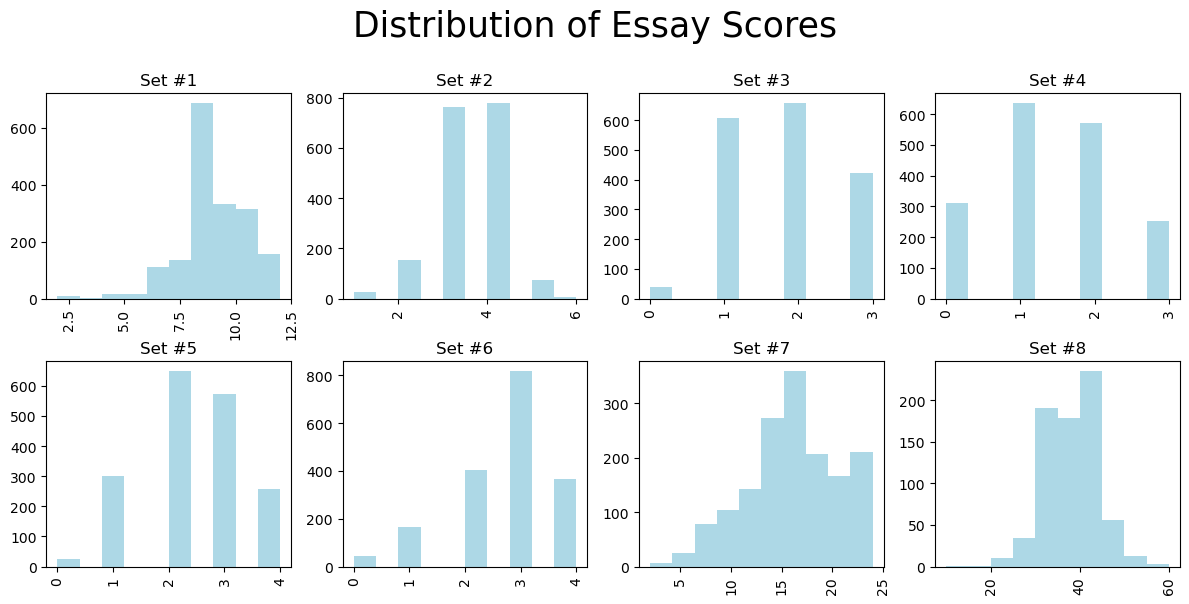

In [83]:
def create_plot(df, title):
    fig, ax = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle(title, size=25, y=1.0)
    plots = df.hist('domain1_score', by='essay_set', ax=ax, color='lightblue').flatten()
    for p in plots:
        p.set_title("Set #{n}".format(n=p.title.get_text()))
    fig.tight_layout()
    
create_plot(essays_train, title="Distribution of Essay Scores")

### Histogram for standardized scores

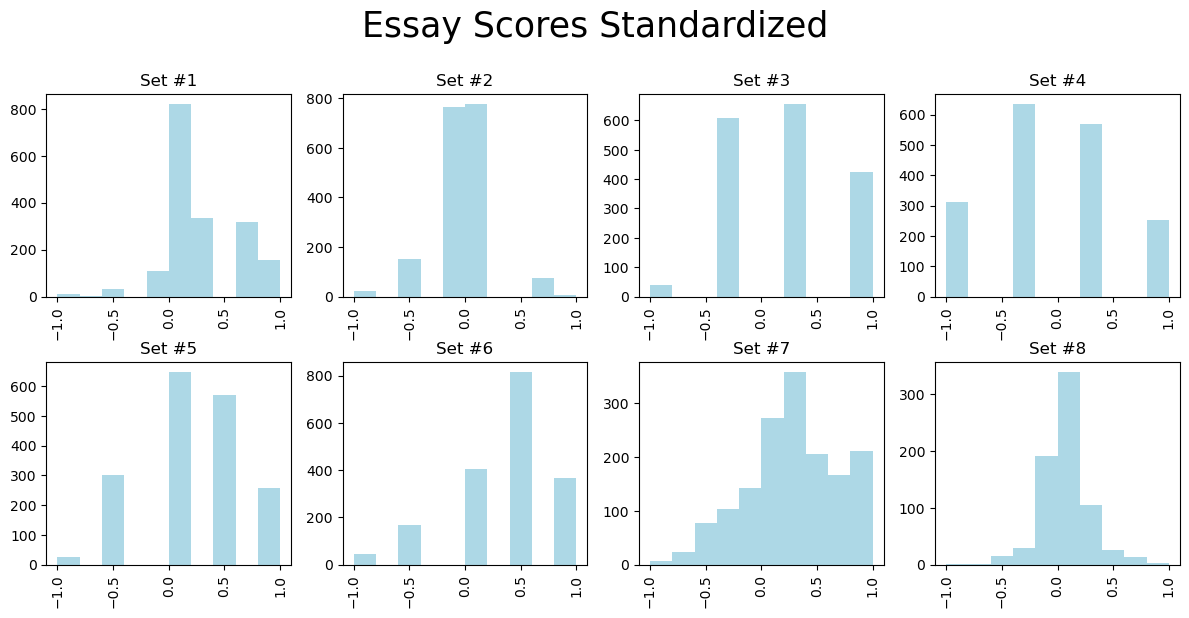

In [84]:
def standardize_df(df):
    new_df = df.copy()
    new_df['domain1_score'] = 2*((df['domain1_score'] - df['domain1_score'].min()) / (df['domain1_score'].max() - df['domain1_score'].min())) - 1.0
    return new_df
    
sub_dfs = []
for g in essays_train.groupby('essay_set'):
    sub_dfs.append( standardize_df(g[1]) )
std_train = pd.concat(sub_dfs).reset_index()

create_plot(std_train, title="Essay Scores Standardized")

### Unique values for domain1_score (by group)

In [94]:
for i in range(1, 9):
    print("Set #{n}:   {v}".format(n=i, v=list(essays_train['domain1_score'][essays_train['essay_set']==i].unique())))
    
# -------------------- OBSERVATIONS --------------------
#
#  - Some of these look like they could be categorical rather than continuous. (particularly sets #2, #3, #4, #5, and #6)

Set #1:   [8, 9, 7, 10, 6, 12, 4, 3, 11, 2, 5]
Set #2:   [4, 1, 2, 5, 3, 6]
Set #3:   [1, 2, 0, 3]
Set #4:   [0, 3, 2, 1, <NA>]
Set #5:   [2, 3, 1, 4, 0]
Set #6:   [2, 3, 4, 1, 0]
Set #7:   [15, 13, 17, 23, 16, 18, 12, 10, 19, 14, 21, 24, 9, 6, 11, 20, 7, 8, 22, 4, 5, 2, 3]
Set #8:   [34, 46, 40, 30, 26, 41, 31, 44, 36, 43, 20, 45, 35, 42, 33, 38, 47, 32, 50, 39, 37, 55, 60, 28, 49, 29, 27, 24, 15, 25, 48, 21, 22, 10]


### Sample Essays:

In [102]:
def show_essays(nsample=1, exclude=None):
    if not exclude: exclude = []
    for group in essays_train.groupby('essay_set'):
        group = group[1].reset_index()
        if not group['essay_set'][0] in exclude:
            print('---------------------------------- (Set {t}) --------------------------------'.format(t=group['essay_set'][0]))
            for _, row in group.sample(n=nsample).iterrows():
                score = row['domain1_score']
                print('\n(Score: {s})  {r}\n'.format(s=score, r=row['essay']))
                print("---------------------------------------------------------------------------")
                
show_essays()

---------------------------------- (Set 1) --------------------------------

(Score: 11)  Dear @LOCATION1, @CAPS1 you imagine where the world would be without computers? Our daily lives would be dull and boring without new technology. Computers help society do various activities that would be impossible if we didn't have computers. They give us the ability to learn at home, connect with other people, and give a source of entertainment. From these reasons our lives because easy and convenient, which is what @CAPS2 people strive to accomplish. The ability for an average person to learn has greatly increased. It has gone from just being able to go to school to the @CAPS2 various ways to increase your intelligence on the computer. Programs such as @ORGANIZATION1, which teaches people how to speak a language, are available on the computer. These programs are like going to school, but more accesible to the public. To further help the public, there are ways to gain college degrees online. tha

### Summary Statistics

In [5]:
NER_tokens = []

for dataset in ['all', *essays_train['essay_set'].unique()]:
    data = essays_train if (dataset=='all') else essays_train[essays_train['essay_set']==dataset]
    
    word_tokens = set()
    char_tokens = set()
    sum_rev_len = 0
    for text in data['essay']:
        sum_rev_len += len(text)
        for token in re.split(r'\s{1,}', text):  word_tokens.add(token)
        for c in text:  char_tokens.add(c)
    print("------------- (Set {s}) --------------".format(s=dataset))
    print("# Essays:  ", len(data))
    print("# Unique words:  ", len(word_tokens))
    print("# Unique characters:  ", len(char_tokens))
    print("Average Essay Length:  ", np.round_(sum_rev_len / len(data), 2), "chars")
    if dataset == 'all':  NER_tokens = [w for w in word_tokens if w.startswith('@')]
    print()
print()
print("Unique NER Tokens ({c}):  {s}\n\n".format(c=len(NER_tokens), s=NER_tokens))

------------- (Set all) --------------
# Essays:   12978
# Unique words:   78395
# Unique characters:   101
Average Essay Length:   1215.63 chars

------------- (Set 1) --------------
# Essays:   1783
# Unique words:   27282
# Unique characters:   91
Average Essay Length:   2029.33 chars

------------- (Set 2) --------------
# Essays:   1800
# Unique words:   24810
# Unique characters:   86
Average Essay Length:   2097.03 chars

------------- (Set 3) --------------
# Essays:   1726
# Unique words:   11074
# Unique characters:   80
Average Essay Length:   586.9 chars

------------- (Set 4) --------------
# Essays:   1772
# Unique words:   8339
# Unique characters:   84
Average Essay Length:   509.48 chars

------------- (Set 5) --------------
# Essays:   1805
# Unique words:   9118
# Unique characters:   82
Average Essay Length:   685.35 chars

------------- (Set 6) --------------
# Essays:   1800
# Unique words:   9729
# Unique characters:   85
Average Essay Length:   892.53 chars

---

### NER Tokens

* How many unique NER tokens are there? What are they?

In [49]:
NER_tokens = set()
types = set()
count = {}

for text in essays_train['essay']:
    for token in re.split(r'\s{1,}', text):
        if(token.startswith('@')):
            result = re.search("@+[A-Z]+[0-9]*", token)
            if result:
                NER_tokens.add(result.group(0))
                types.add(re.search("@+[A-Z]+", token).group(0))
                if result.group(0) not in count:
                    count[result.group(0)] = 1
                else:
                    count[result.group(0)] += 1
    
print("Token Types: ({c}):  {s}\n".format(c=len(types), s=list(sorted(types))))
print("Unique Tokens: ({c}):  {s}\n".format(c=len(NER_tokens), s=list(sorted(NER_tokens))))
print("Counts: ", dict(sorted(count.items(), key=lambda x: x[0])))

# -------------------- OBSERVATIONS --------------------
#
# - It appears that NER tokens have a number that comes after, perhaps indicating the number of that type of instance
#   in each essay. This is reinforced by the fact that the lower the number, the higher the count (Ex: '@CAPS1: 10,509',
#   '@LOCATION6: 8')
#
# - It's probably best to leave only the unqiue 'Token Types' tokenized, not including the number that comes after.
#   Byte-pair encoding could probably take care of that. 

Token Types: (14):  ['@CAPS', '@CITY', '@DATE', '@DR', '@EMAIL', '@LOCATION', '@MONEY', '@MONTH', '@NUM', '@ORGANIZATION', '@PERCENT', '@PERSON', '@STATE', '@TIME']

Unique Tokens: (118):  ['@CAPS1', '@CAPS10', '@CAPS11', '@CAPS12', '@CAPS13', '@CAPS14', '@CAPS15', '@CAPS16', '@CAPS17', '@CAPS18', '@CAPS19', '@CAPS2', '@CAPS20', '@CAPS21', '@CAPS22', '@CAPS23', '@CAPS24', '@CAPS25', '@CAPS26', '@CAPS27', '@CAPS28', '@CAPS29', '@CAPS3', '@CAPS30', '@CAPS31', '@CAPS32', '@CAPS33', '@CAPS34', '@CAPS35', '@CAPS36', '@CAPS38', '@CAPS39', '@CAPS4', '@CAPS40', '@CAPS41', '@CAPS43', '@CAPS46', '@CAPS49', '@CAPS5', '@CAPS53', '@CAPS54', '@CAPS56', '@CAPS6', '@CAPS62', '@CAPS63', '@CAPS66', '@CAPS67', '@CAPS7', '@CAPS73', '@CAPS8', '@CAPS9', '@CITY1', '@DATE1', '@DATE2', '@DATE3', '@DATE4', '@DATE5', '@DATE6', '@DR1', '@DR2', '@EMAIL1', '@LOCATION1', '@LOCATION10', '@LOCATION11', '@LOCATION12', '@LOCATION2', '@LOCATION3', '@LOCATION4', '@LOCATION5', '@LOCATION6', '@LOCATION7', '@LOCATION8', '@LO